In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Machine Learning in Network Science
Lab 2: Link prediction
"""
%matplotlib inline
import os
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
# Read network files
karate = nx.read_gml("./karate.gml")

facebook = nx.read_edgelist('socfb-Caltech36.mtx') # bigger so computations take more time
nodes = max(nx.connected_components(facebook), key=len) 
facebook = facebook.subgraph(nodes) # has several connected components

# Choose a network
G = facebook
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))

The number of nodes: 762
The number of edges: 16651


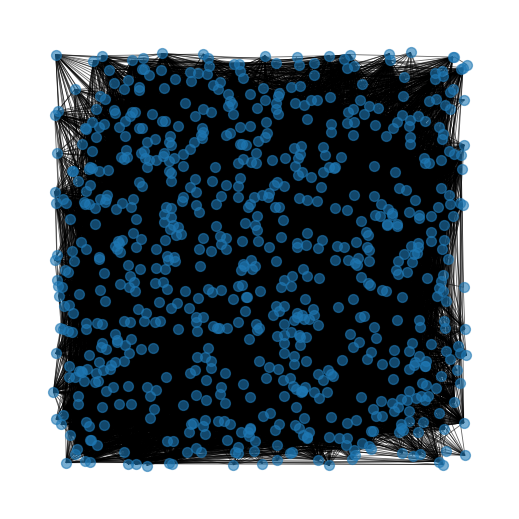

In [3]:
# Plot graph
plt.figure(figsize=(5,5))

pos = nx.random_layout(G, seed=19)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)

plt.show()

# Unsupervised link prediction

In this section, we adopt an unsupervised approach for the link prediction task. In particular, we implement various similarity metrics (seen in class) and use them to predict future edges. 

In [4]:
def preferential_attachement(graph):
    PA = {}
    
    non_edges = nx.non_edges(G)
    for edge in non_edges:
        PA[edge] = graph.degree(edge[0]) * graph.degree(edge[1])
        
    return PA
    
pa = preferential_attachement(G)
# list(nx.preferential_attachment(G))

In [5]:
def Jaccard(graph):
    Jaccard = {}
    
    # Fill in the blanks
    non_edges = nx.non_edges(graph)
    for edge in non_edges: 
        inter = list(nx.common_neighbors(graph, edge[0], edge[1]))
        union = set(list(nx.neighbors(graph, edge[0])) + list(nx.neighbors(graph, edge[1])))
        #union = (set(graph[edge[0]]) | set(graph[edge[1]]))
        if len(union) > 0: 
            Jaccard[edge] = len(inter) / len(union)
        else: 
            Jaccard[edge] == 0
    return Jaccard

jc = Jaccard(G)
# list(nx.jaccard_coefficient(G)) 

In [6]:
def AdamicAdar(graph):
    AdamicAdar = {}
    
    non_edges = nx.non_edges(G)
    for edge in non_edges: 
        inter_list = nx.common_neighbors(graph, edge[0], edge[1])
        AdamicAdar[edge] = sum( [1/np.log(graph.degree(node)) for node in inter_list] )
    
    return AdamicAdar

aa = AdamicAdar(G)

In [7]:
def predict_edges(metric):
    
    # Shuffle randomly entries of dictionnary 
    l = list(metric.items())
    np.random.seed(10) # fix random seed to obtain same random shuffling when repeating experiment
    np.random.shuffle(l)
    metric = dict(l)

    # Retrieve top k value 
    k = 10
    metric = dict(sorted(metric.items(), key=lambda x:x[1], reverse=True)[:k])
    print(metric.items())

predict_edges(pa)

dict_items([(('33', '0'), 272), (('32', '0'), 192), (('33', '2'), 170), (('1', '33'), 153), (('32', '1'), 108), (('3', '33'), 102), (('23', '0'), 80), (('3', '32'), 72), (('5', '33'), 68), (('6', '33'), 68)])


In [12]:
def evaluation(G):
    graph = G.copy()
    k = int(0.2 * graph.number_of_nodes() ) # number of edges to predict

    # We remove k true edges of the graph at random 
    pos_test_set = list(graph.edges())
    np.random.seed(10)
    np.random.shuffle(pos_test_set)
    gt = []
    i=0
    for edge in pos_test_set:
        graph.remove_edge(edge[0], edge[1]) 
        if not nx.is_connected(graph):
            graph.add_edge(edge[0], edge[1])
        else: 
            i += 1
            gt.append(edge)
        if i == k:
            break
            
    # --- Apply each method defined above and calculate its accuracy ---
    methods = ['Jaccard', 'AdamicAdar', 'preferential_attachement']
    
    # For each method, compute the similarity scores between all non-edges
    # Predict k node pairs with highest score 
    # Compute accuracy wrt edges actually removed 
    for method in methods: 
        res = eval(method)(graph)
        pred = sorted(res.items(), key = lambda x:x[1], reverse=True)[:k]
        pred = [el[0] for el in pred]
        print('pred', pred)
        print('gt',gt)
        accuracy = len(set(pred).intersection(set(gt))) / k
        print(method, accuracy)

evaluation(G)

pred [('15', '14'), ('15', '18'), ('15', '22'), ('15', '20'), ('21', '17'), ('9', '28')]
gt [('32', '8'), ('29', '26'), ('28', '31'), ('1', '13'), ('1', '0'), ('8', '2')]
Jaccard 0.0
pred [('33', '2'), ('33', '0'), ('5', '4'), ('6', '10'), ('23', '31'), ('1', '33')]
gt [('32', '8'), ('29', '26'), ('28', '31'), ('1', '13'), ('1', '0'), ('8', '2')]
AdamicAdar 0.0
pred [('33', '0'), ('32', '0'), ('33', '2'), ('1', '33'), ('3', '33'), ('32', '1')]
gt [('32', '8'), ('29', '26'), ('28', '31'), ('1', '13'), ('1', '0'), ('8', '2')]
preferential_attachement 0.0


# Supervised link prediction

In this section, we adopt a supervised approach for the link prediction task. We thus first pre-process the dataset so as to create labels for each edge, then derive a feature vector for each edge, before passing it to a traditional deep learning approach that classifies the edge into one of two categories. 

In [5]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(G) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in edges:
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels


In [6]:
def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Fill in the blanks

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Betweeness centrality measure
    betweeness_centrality = nx.betweenness_centrality(graph)

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality measure 
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]

        # Jaccard
        jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]
        
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        diff_bt, pref_attach, aai, jacard_coeff]) ) 
        
    return feature_vector

In [7]:
def prediction(graph, train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

100%|██████████| 13320/13320 [00:02<00:00, 5794.25it/s]


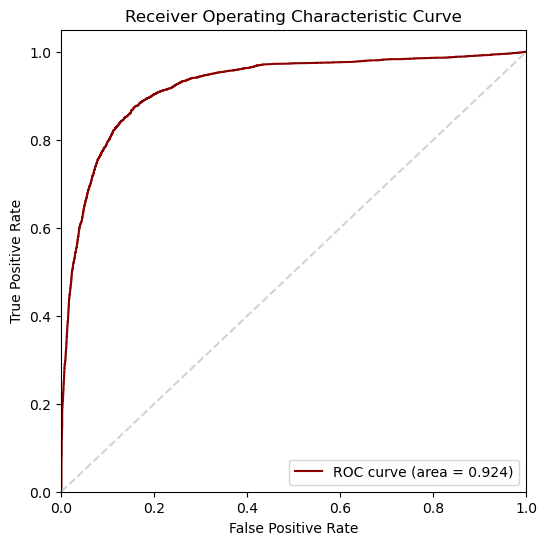

0.9235640821001182

In [8]:
# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.6)

# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(residual_g, train_samples)
test_features = feature_extractor(residual_g, test_samples)

# --- Link prediction ---
prediction(residual_g, train_features, test_features, train_labels, test_labels)